# rnnlm.py

In [26]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.time_layers import *
#from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


# better_rnnlm.py

In [27]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.time_layers import *
#from common.np import *  # import numpy as np
#from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

# clip_grads.py

In [28]:
# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())


before: [5.04887101 1.39367805 0.26751679 9.66814467 0.17304446 9.06564587
 0.55717293 1.99489946 0.27001697]
after: [1.37950872 0.38079622 0.07309391 2.64163808 0.04728113 2.47701665
 0.15223699 0.54506863 0.07377704]


# rnn_gradient_graph.py

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: Runtim

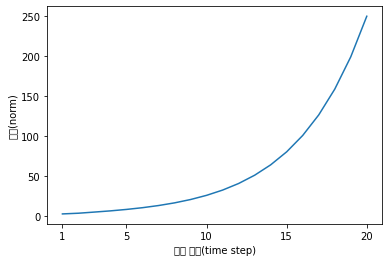

In [29]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()


# train_rnnlm.py

| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 9996.42
| 에폭 1 |  반복 21 / 1327 | 시간 17[s] | 퍼플렉서티 2871.38
| 에폭 1 |  반복 41 / 1327 | 시간 32[s] | 퍼플렉서티 1209.36
| 에폭 1 |  반복 61 / 1327 | 시간 42[s] | 퍼플렉서티 956.09
| 에폭 1 |  반복 81 / 1327 | 시간 52[s] | 퍼플렉서티 802.61
| 에폭 1 |  반복 101 / 1327 | 시간 62[s] | 퍼플렉서티 645.99
| 에폭 1 |  반복 121 / 1327 | 시간 74[s] | 퍼플렉서티 646.51
| 에폭 1 |  반복 141 / 1327 | 시간 85[s] | 퍼플렉서티 610.41
| 에폭 1 |  반복 161 / 1327 | 시간 97[s] | 퍼플렉서티 566.09
| 에폭 1 |  반복 181 / 1327 | 시간 108[s] | 퍼플렉서티 597.39
| 에폭 1 |  반복 201 / 1327 | 시간 118[s] | 퍼플렉서티 511.05
| 에폭 1 |  반복 221 / 1327 | 시간 128[s] | 퍼플렉서티 488.65
| 에폭 1 |  반복 241 / 1327 | 시간 139[s] | 퍼플렉서티 452.54
| 에폭 1 |  반복 261 / 1327 | 시간 149[s] | 퍼플렉서티 466.79
| 에폭 1 |  반복 281 / 1327 | 시간 159[s] | 퍼플렉서티 455.55
| 에폭 1 |  반복 301 / 1327 | 시간 169[s] | 퍼플렉서티 391.53
| 에폭 1 |  반복 321 / 1327 | 시간 180[s] | 퍼플렉서티 350.47
| 에폭 1 |  반복 341 / 1327 | 시간 189[s] | 퍼플렉서티 400.35
| 에폭 1 |  반복 361 / 1327 | 시간 200[s] | 퍼플렉서티 404.54
| 에폭 1 |  반복 381 / 1327 | 시간 212[s] | 퍼플렉서티 

| 에폭 3 |  반복 521 / 1327 | 시간 1184[s] | 퍼플렉서티 136.31
| 에폭 3 |  반복 541 / 1327 | 시간 1190[s] | 퍼플렉서티 134.81
| 에폭 3 |  반복 561 / 1327 | 시간 1196[s] | 퍼플렉서티 117.81
| 에폭 3 |  반복 581 / 1327 | 시간 1202[s] | 퍼플렉서티 105.03
| 에폭 3 |  반복 601 / 1327 | 시간 1208[s] | 퍼플렉서티 147.72
| 에폭 3 |  반복 621 / 1327 | 시간 1214[s] | 퍼플렉서티 140.19
| 에폭 3 |  반복 641 / 1327 | 시간 1220[s] | 퍼플렉서티 127.22
| 에폭 3 |  반복 661 / 1327 | 시간 1226[s] | 퍼플렉서티 118.98
| 에폭 3 |  반복 681 / 1327 | 시간 1232[s] | 퍼플렉서티 98.33
| 에폭 3 |  반복 701 / 1327 | 시간 1238[s] | 퍼플렉서티 116.83
| 에폭 3 |  반복 721 / 1327 | 시간 1244[s] | 퍼플렉서티 125.21
| 에폭 3 |  반복 741 / 1327 | 시간 1250[s] | 퍼플렉서티 106.88
| 에폭 3 |  반복 761 / 1327 | 시간 1256[s] | 퍼플렉서티 101.10
| 에폭 3 |  반복 781 / 1327 | 시간 1262[s] | 퍼플렉서티 103.05
| 에폭 3 |  반복 801 / 1327 | 시간 1268[s] | 퍼플렉서티 116.22
| 에폭 3 |  반복 821 / 1327 | 시간 1274[s] | 퍼플렉서티 116.60
| 에폭 3 |  반복 841 / 1327 | 시간 1280[s] | 퍼플렉서티 112.89
| 에폭 3 |  반복 861 / 1327 | 시간 1285[s] | 퍼플렉서티 118.68
| 에폭 3 |  반복 881 / 1327 | 시간 1291[s] | 퍼플렉서티 104.57
| 에폭 3 |  반복 

/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: Runtim

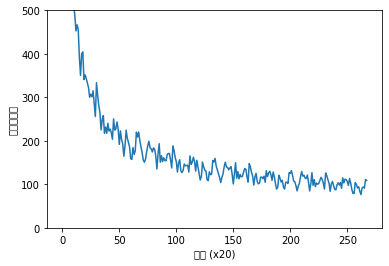

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.59310124416652


In [30]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.optimizer import SGD
#from common.trainer import RnnlmTrainer
#from common.util import eval_perplexity
from dataset import ptb
#from rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()


In [ ]:
"""
| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 9996.42
| 에폭 1 |  반복 21 / 1327 | 시간 17[s] | 퍼플렉서티 2871.38
| 에폭 1 |  반복 41 / 1327 | 시간 32[s] | 퍼플렉서티 1209.36
| 에폭 1 |  반복 61 / 1327 | 시간 42[s] | 퍼플렉서티 956.09
| 에폭 1 |  반복 81 / 1327 | 시간 52[s] | 퍼플렉서티 802.61
| 에폭 1 |  반복 101 / 1327 | 시간 62[s] | 퍼플렉서티 645.99
| 에폭 1 |  반복 121 / 1327 | 시간 74[s] | 퍼플렉서티 646.51
| 에폭 1 |  반복 141 / 1327 | 시간 85[s] | 퍼플렉서티 610.41
| 에폭 1 |  반복 161 / 1327 | 시간 97[s] | 퍼플렉서티 566.09
| 에폭 1 |  반복 181 / 1327 | 시간 108[s] | 퍼플렉서티 597.39
| 에폭 1 |  반복 201 / 1327 | 시간 118[s] | 퍼플렉서티 511.05
| 에폭 1 |  반복 221 / 1327 | 시간 128[s] | 퍼플렉서티 488.65
| 에폭 1 |  반복 241 / 1327 | 시간 139[s] | 퍼플렉서티 452.54
| 에폭 1 |  반복 261 / 1327 | 시간 149[s] | 퍼플렉서티 466.79
| 에폭 1 |  반복 281 / 1327 | 시간 159[s] | 퍼플렉서티 455.55
| 에폭 1 |  반복 301 / 1327 | 시간 169[s] | 퍼플렉서티 391.53
| 에폭 1 |  반복 321 / 1327 | 시간 180[s] | 퍼플렉서티 350.47
| 에폭 1 |  반복 341 / 1327 | 시간 189[s] | 퍼플렉서티 400.35
| 에폭 1 |  반복 361 / 1327 | 시간 200[s] | 퍼플렉서티 404.54
| 에폭 1 |  반복 381 / 1327 | 시간 212[s] | 퍼플렉서티 340.74
| 에폭 1 |  반복 401 / 1327 | 시간 223[s] | 퍼플렉서티 351.58
| 에폭 1 |  반복 421 / 1327 | 시간 235[s] | 퍼플렉서티 343.35
| 에폭 1 |  반복 441 / 1327 | 시간 247[s] | 퍼플렉서티 333.37
| 에폭 1 |  반복 461 / 1327 | 시간 260[s] | 퍼플렉서티 322.75
| 에폭 1 |  반복 481 / 1327 | 시간 269[s] | 퍼플렉서티 300.20
| 에폭 1 |  반복 501 / 1327 | 시간 280[s] | 퍼플렉서티 307.12
| 에폭 1 |  반복 521 / 1327 | 시간 291[s] | 퍼플렉서티 301.28
| 에폭 1 |  반복 541 / 1327 | 시간 300[s] | 퍼플렉서티 314.97
| 에폭 1 |  반복 561 / 1327 | 시간 309[s] | 퍼플렉서티 284.79
| 에폭 1 |  반복 581 / 1327 | 시간 317[s] | 퍼플렉서티 255.90
| 에폭 1 |  반복 601 / 1327 | 시간 326[s] | 퍼플렉서티 333.54
| 에폭 1 |  반복 621 / 1327 | 시간 335[s] | 퍼플렉서티 305.43
| 에폭 1 |  반복 641 / 1327 | 시간 343[s] | 퍼플렉서티 281.06
| 에폭 1 |  반복 661 / 1327 | 시간 352[s] | 퍼플렉서티 265.18
| 에폭 1 |  반복 681 / 1327 | 시간 360[s] | 퍼플렉서티 225.14
| 에폭 1 |  반복 701 / 1327 | 시간 369[s] | 퍼플렉서티 248.17
| 에폭 1 |  반복 721 / 1327 | 시간 378[s] | 퍼플렉서티 257.91
| 에폭 1 |  반복 741 / 1327 | 시간 386[s] | 퍼플렉서티 216.82
| 에폭 1 |  반복 761 / 1327 | 시간 395[s] | 퍼플렉서티 231.75
| 에폭 1 |  반복 781 / 1327 | 시간 403[s] | 퍼플렉서티 217.34
| 에폭 1 |  반복 801 / 1327 | 시간 412[s] | 퍼플렉서티 240.33
| 에폭 1 |  반복 821 / 1327 | 시간 421[s] | 퍼플렉서티 222.60
| 에폭 1 |  반복 841 / 1327 | 시간 429[s] | 퍼플렉서티 226.80
| 에폭 1 |  반복 861 / 1327 | 시간 438[s] | 퍼플렉서티 218.47
| 에폭 1 |  반복 881 / 1327 | 시간 446[s] | 퍼플렉서티 203.57
| 에폭 1 |  반복 901 / 1327 | 시간 455[s] | 퍼플렉서티 250.47
| 에폭 1 |  반복 921 / 1327 | 시간 463[s] | 퍼플렉서티 224.69
| 에폭 1 |  반복 941 / 1327 | 시간 472[s] | 퍼플렉서티 227.66
| 에폭 1 |  반복 961 / 1327 | 시간 481[s] | 퍼플렉서티 243.35
| 에폭 1 |  반복 981 / 1327 | 시간 489[s] | 퍼플렉서티 227.33
| 에폭 1 |  반복 1001 / 1327 | 시간 498[s] | 퍼플렉서티 191.82
| 에폭 1 |  반복 1021 / 1327 | 시간 507[s] | 퍼플렉서티 222.93
| 에폭 1 |  반복 1041 / 1327 | 시간 515[s] | 퍼플렉서티 203.26
| 에폭 1 |  반복 1061 / 1327 | 시간 524[s] | 퍼플렉서티 193.00
| 에폭 1 |  반복 1081 / 1327 | 시간 533[s] | 퍼플렉서티 164.56
| 에폭 1 |  반복 1101 / 1327 | 시간 541[s] | 퍼플렉서티 187.68
| 에폭 1 |  반복 1121 / 1327 | 시간 550[s] | 퍼플렉서티 224.68
| 에폭 1 |  반복 1141 / 1327 | 시간 558[s] | 퍼플렉서티 206.42
| 에폭 1 |  반복 1161 / 1327 | 시간 567[s] | 퍼플렉서티 196.77
| 에폭 1 |  반복 1181 / 1327 | 시간 575[s] | 퍼플렉서티 186.31
| 에폭 1 |  반복 1201 / 1327 | 시간 584[s] | 퍼플렉서티 159.00
| 에폭 1 |  반복 1221 / 1327 | 시간 592[s] | 퍼플렉서티 157.22
| 에폭 1 |  반복 1241 / 1327 | 시간 601[s] | 퍼플렉서티 184.63
| 에폭 1 |  반복 1261 / 1327 | 시간 609[s] | 퍼플렉서티 168.66
| 에폭 1 |  반복 1281 / 1327 | 시간 615[s] | 퍼플렉서티 176.74
| 에폭 1 |  반복 1301 / 1327 | 시간 626[s] | 퍼플렉서티 219.93
| 에폭 1 |  반복 1321 / 1327 | 시간 634[s] | 퍼플렉서티 208.66
| 에폭 2 |  반복 1 / 1327 | 시간 638[s] | 퍼플렉서티 220.30
| 에폭 2 |  반복 21 / 1327 | 시간 644[s] | 퍼플렉서티 201.39
| 에폭 2 |  반복 41 / 1327 | 시간 650[s] | 퍼플렉서티 186.53
| 에폭 2 |  반복 61 / 1327 | 시간 656[s] | 퍼플렉서티 173.17
| 에폭 2 |  반복 81 / 1327 | 시간 662[s] | 퍼플렉서티 156.09
| 에폭 2 |  반복 101 / 1327 | 시간 668[s] | 퍼플렉서티 150.83
| 에폭 2 |  반복 121 / 1327 | 시간 674[s] | 퍼플렉서티 157.54
| 에폭 2 |  반복 141 / 1327 | 시간 680[s] | 퍼플렉서티 174.85
| 에폭 2 |  반복 161 / 1327 | 시간 686[s] | 퍼플렉서티 189.06
| 에폭 2 |  반복 181 / 1327 | 시간 692[s] | 퍼플렉서티 198.87
| 에폭 2 |  반복 201 / 1327 | 시간 698[s] | 퍼플렉서티 183.73
| 에폭 2 |  반복 221 / 1327 | 시간 703[s] | 퍼플렉서티 181.54
| 에폭 2 |  반복 241 / 1327 | 시간 709[s] | 퍼플렉서티 174.37
| 에폭 2 |  반복 261 / 1327 | 시간 715[s] | 퍼플렉서티 183.84
| 에폭 2 |  반복 281 / 1327 | 시간 721[s] | 퍼플렉서티 180.84
| 에폭 2 |  반복 301 / 1327 | 시간 727[s] | 퍼플렉서티 165.28
| 에폭 2 |  반복 321 / 1327 | 시간 733[s] | 퍼플렉서티 135.38
| 에폭 2 |  반복 341 / 1327 | 시간 739[s] | 퍼플렉서티 170.21
| 에폭 2 |  반복 361 / 1327 | 시간 745[s] | 퍼플렉서티 193.39
| 에폭 2 |  반복 381 / 1327 | 시간 750[s] | 퍼플렉서티 150.73
| 에폭 2 |  반복 401 / 1327 | 시간 756[s] | 퍼플렉서티 165.71
| 에폭 2 |  반복 421 / 1327 | 시간 762[s] | 퍼플렉서티 152.27
| 에폭 2 |  반복 441 / 1327 | 시간 768[s] | 퍼플렉서티 161.07
| 에폭 2 |  반복 461 / 1327 | 시간 774[s] | 퍼플렉서티 154.59
| 에폭 2 |  반복 481 / 1327 | 시간 780[s] | 퍼플렉서티 153.99
| 에폭 2 |  반복 501 / 1327 | 시간 786[s] | 퍼플렉서티 167.63
| 에폭 2 |  반복 521 / 1327 | 시간 792[s] | 퍼플렉서티 170.99
| 에폭 2 |  반복 541 / 1327 | 시간 798[s] | 퍼플렉서티 170.68
| 에폭 2 |  반복 561 / 1327 | 시간 804[s] | 퍼플렉서티 155.43
| 에폭 2 |  반복 581 / 1327 | 시간 810[s] | 퍼플렉서티 137.56
| 에폭 2 |  반복 601 / 1327 | 시간 816[s] | 퍼플렉서티 188.16
| 에폭 2 |  반복 621 / 1327 | 시간 822[s] | 퍼플렉서티 177.78
| 에폭 2 |  반복 641 / 1327 | 시간 827[s] | 퍼플렉서티 161.75
| 에폭 2 |  반복 661 / 1327 | 시간 833[s] | 퍼플렉서티 152.28
| 에폭 2 |  반복 681 / 1327 | 시간 839[s] | 퍼플렉서티 128.13
| 에폭 2 |  반복 701 / 1327 | 시간 845[s] | 퍼플렉서티 148.91
| 에폭 2 |  반복 721 / 1327 | 시간 851[s] | 퍼플렉서티 156.50
| 에폭 2 |  반복 741 / 1327 | 시간 857[s] | 퍼플렉서티 130.82
| 에폭 2 |  반복 761 / 1327 | 시간 863[s] | 퍼플렉서티 126.90
| 에폭 2 |  반복 781 / 1327 | 시간 869[s] | 퍼플렉서티 132.03
| 에폭 2 |  반복 801 / 1327 | 시간 875[s] | 퍼플렉서티 146.82
| 에폭 2 |  반복 821 / 1327 | 시간 881[s] | 퍼플렉서티 142.69
| 에폭 2 |  반복 841 / 1327 | 시간 887[s] | 퍼플렉서티 142.94
| 에폭 2 |  반복 861 / 1327 | 시간 892[s] | 퍼플렉서티 143.97
| 에폭 2 |  반복 881 / 1327 | 시간 898[s] | 퍼플렉서티 128.11
| 에폭 2 |  반복 901 / 1327 | 시간 904[s] | 퍼플렉서티 165.41
| 에폭 2 |  반복 921 / 1327 | 시간 910[s] | 퍼플렉서티 145.82
| 에폭 2 |  반복 941 / 1327 | 시간 916[s] | 퍼플렉서티 150.93
| 에폭 2 |  반복 961 / 1327 | 시간 922[s] | 퍼플렉서티 162.22
| 에폭 2 |  반복 981 / 1327 | 시간 928[s] | 퍼플렉서티 152.87
| 에폭 2 |  반복 1001 / 1327 | 시간 934[s] | 퍼플렉서티 130.45
| 에폭 2 |  반복 1021 / 1327 | 시간 940[s] | 퍼플렉서티 155.32
| 에폭 2 |  반복 1041 / 1327 | 시간 946[s] | 퍼플렉서티 139.98
| 에폭 2 |  반복 1061 / 1327 | 시간 953[s] | 퍼플렉서티 125.97
| 에폭 2 |  반복 1081 / 1327 | 시간 958[s] | 퍼플렉서티 109.93
| 에폭 2 |  반복 1101 / 1327 | 시간 964[s] | 퍼플렉서티 117.97
| 에폭 2 |  반복 1121 / 1327 | 시간 970[s] | 퍼플렉서티 151.04
| 에폭 2 |  반복 1141 / 1327 | 시간 976[s] | 퍼플렉서티 140.26
| 에폭 2 |  반복 1161 / 1327 | 시간 982[s] | 퍼플렉서티 132.36
| 에폭 2 |  반복 1181 / 1327 | 시간 988[s] | 퍼플렉서티 131.08
| 에폭 2 |  반복 1201 / 1327 | 시간 994[s] | 퍼플렉서티 110.88
| 에폭 2 |  반복 1221 / 1327 | 시간 999[s] | 퍼플렉서티 108.43
| 에폭 2 |  반복 1241 / 1327 | 시간 1005[s] | 퍼플렉서티 128.71
| 에폭 2 |  반복 1261 / 1327 | 시간 1011[s] | 퍼플렉서티 122.00
| 에폭 2 |  반복 1281 / 1327 | 시간 1017[s] | 퍼플렉서티 123.32
| 에폭 2 |  반복 1301 / 1327 | 시간 1023[s] | 퍼플렉서티 154.89
| 에폭 2 |  반복 1321 / 1327 | 시간 1029[s] | 퍼플렉서티 151.35
| 에폭 3 |  반복 1 / 1327 | 시간 1031[s] | 퍼플렉서티 159.66
| 에폭 3 |  반복 21 / 1327 | 시간 1037[s] | 퍼플렉서티 142.07
| 에폭 3 |  반복 41 / 1327 | 시간 1042[s] | 퍼플렉서티 133.34
| 에폭 3 |  반복 61 / 1327 | 시간 1048[s] | 퍼플렉서티 124.70
| 에폭 3 |  반복 81 / 1327 | 시간 1054[s] | 퍼플렉서티 115.39
| 에폭 3 |  반복 101 / 1327 | 시간 1060[s] | 퍼플렉서티 103.98
| 에폭 3 |  반복 121 / 1327 | 시간 1066[s] | 퍼플렉서티 115.81
| 에폭 3 |  반복 141 / 1327 | 시간 1072[s] | 퍼플렉서티 123.90
| 에폭 3 |  반복 161 / 1327 | 시간 1078[s] | 퍼플렉서티 140.46
| 에폭 3 |  반복 181 / 1327 | 시간 1083[s] | 퍼플렉서티 150.90
| 에폭 3 |  반복 201 / 1327 | 시간 1089[s] | 퍼플렉서티 139.69
| 에폭 3 |  반복 221 / 1327 | 시간 1095[s] | 퍼플렉서티 138.81
| 에폭 3 |  반복 241 / 1327 | 시간 1101[s] | 퍼플렉서티 133.44
| 에폭 3 |  반복 261 / 1327 | 시간 1107[s] | 퍼플렉서티 137.37
| 에폭 3 |  반복 281 / 1327 | 시간 1113[s] | 퍼플렉서티 140.67
| 에폭 3 |  반복 301 / 1327 | 시간 1119[s] | 퍼플렉서티 123.25
| 에폭 3 |  반복 321 / 1327 | 시간 1125[s] | 퍼플렉서티 100.69
| 에폭 3 |  반복 341 / 1327 | 시간 1131[s] | 퍼플렉서티 123.83
| 에폭 3 |  반복 361 / 1327 | 시간 1137[s] | 퍼플렉서티 149.65
| 에폭 3 |  반복 381 / 1327 | 시간 1143[s] | 퍼플렉서티 113.97
| 에폭 3 |  반복 401 / 1327 | 시간 1149[s] | 퍼플렉서티 129.24
| 에폭 3 |  반복 421 / 1327 | 시간 1155[s] | 퍼플렉서티 112.57
| 에폭 3 |  반복 441 / 1327 | 시간 1161[s] | 퍼플렉서티 122.72
| 에폭 3 |  반복 461 / 1327 | 시간 1167[s] | 퍼플렉서티 117.02
| 에폭 3 |  반복 481 / 1327 | 시간 1173[s] | 퍼플렉서티 118.34
| 에폭 3 |  반복 501 / 1327 | 시간 1178[s] | 퍼플렉서티 127.90
| 에폭 3 |  반복 521 / 1327 | 시간 1184[s] | 퍼플렉서티 136.31
| 에폭 3 |  반복 541 / 1327 | 시간 1190[s] | 퍼플렉서티 134.81
| 에폭 3 |  반복 561 / 1327 | 시간 1196[s] | 퍼플렉서티 117.81
| 에폭 3 |  반복 581 / 1327 | 시간 1202[s] | 퍼플렉서티 105.03
| 에폭 3 |  반복 601 / 1327 | 시간 1208[s] | 퍼플렉서티 147.72
| 에폭 3 |  반복 621 / 1327 | 시간 1214[s] | 퍼플렉서티 140.19
| 에폭 3 |  반복 641 / 1327 | 시간 1220[s] | 퍼플렉서티 127.22
| 에폭 3 |  반복 661 / 1327 | 시간 1226[s] | 퍼플렉서티 118.98
| 에폭 3 |  반복 681 / 1327 | 시간 1232[s] | 퍼플렉서티 98.33
| 에폭 3 |  반복 701 / 1327 | 시간 1238[s] | 퍼플렉서티 116.83
| 에폭 3 |  반복 721 / 1327 | 시간 1244[s] | 퍼플렉서티 125.21
| 에폭 3 |  반복 741 / 1327 | 시간 1250[s] | 퍼플렉서티 106.88
| 에폭 3 |  반복 761 / 1327 | 시간 1256[s] | 퍼플렉서티 101.10
| 에폭 3 |  반복 781 / 1327 | 시간 1262[s] | 퍼플렉서티 103.05
| 에폭 3 |  반복 801 / 1327 | 시간 1268[s] | 퍼플렉서티 116.22
| 에폭 3 |  반복 821 / 1327 | 시간 1274[s] | 퍼플렉서티 116.60
| 에폭 3 |  반복 841 / 1327 | 시간 1280[s] | 퍼플렉서티 112.89
| 에폭 3 |  반복 861 / 1327 | 시간 1285[s] | 퍼플렉서티 118.68
| 에폭 3 |  반복 881 / 1327 | 시간 1291[s] | 퍼플렉서티 104.57
| 에폭 3 |  반복 901 / 1327 | 시간 1297[s] | 퍼플렉서티 131.28
| 에폭 3 |  반복 921 / 1327 | 시간 1303[s] | 퍼플렉서티 117.74
| 에폭 3 |  반복 941 / 1327 | 시간 1309[s] | 퍼플렉서티 125.82
| 에폭 3 |  반복 961 / 1327 | 시간 1315[s] | 퍼플렉서티 130.09
| 에폭 3 |  반복 981 / 1327 | 시간 1321[s] | 퍼플렉서티 122.31
| 에폭 3 |  반복 1001 / 1327 | 시간 1327[s] | 퍼플렉서티 109.05
| 에폭 3 |  반복 1021 / 1327 | 시간 1332[s] | 퍼플렉서티 128.19
| 에폭 3 |  반복 1041 / 1327 | 시간 1338[s] | 퍼플렉서티 117.41
| 에폭 3 |  반복 1061 / 1327 | 시간 1344[s] | 퍼플렉서티 101.86
| 에폭 3 |  반복 1081 / 1327 | 시간 1350[s] | 퍼플렉서티 89.03
| 에폭 3 |  반복 1101 / 1327 | 시간 1356[s] | 퍼플렉서티 93.64
| 에폭 3 |  반복 1121 / 1327 | 시간 1362[s] | 퍼플렉서티 120.87
| 에폭 3 |  반복 1141 / 1327 | 시간 1368[s] | 퍼플렉서티 113.84
| 에폭 3 |  반복 1161 / 1327 | 시간 1373[s] | 퍼플렉서티 105.25
| 에폭 3 |  반복 1181 / 1327 | 시간 1379[s] | 퍼플렉서티 109.26
| 에폭 3 |  반복 1201 / 1327 | 시간 1385[s] | 퍼플렉서티 93.38
| 에폭 3 |  반복 1221 / 1327 | 시간 1391[s] | 퍼플렉서티 89.02
| 에폭 3 |  반복 1241 / 1327 | 시간 1398[s] | 퍼플렉서티 105.01
| 에폭 3 |  반복 1261 / 1327 | 시간 1403[s] | 퍼플렉서티 104.58
| 에폭 3 |  반복 1281 / 1327 | 시간 1409[s] | 퍼플렉서티 102.17
| 에폭 3 |  반복 1301 / 1327 | 시간 1415[s] | 퍼플렉서티 127.12
| 에폭 3 |  반복 1321 / 1327 | 시간 1421[s] | 퍼플렉서티 125.17
| 에폭 4 |  반복 1 / 1327 | 시간 1423[s] | 퍼플렉서티 131.56
| 에폭 4 |  반복 21 / 1327 | 시간 1429[s] | 퍼플렉서티 120.48
| 에폭 4 |  반복 41 / 1327 | 시간 1435[s] | 퍼플렉서티 107.15
| 에폭 4 |  반복 61 / 1327 | 시간 1441[s] | 퍼플렉서티 105.60
| 에폭 4 |  반복 81 / 1327 | 시간 1447[s] | 퍼플렉서티 96.69
| 에폭 4 |  반복 101 / 1327 | 시간 1453[s] | 퍼플렉서티 84.88
| 에폭 4 |  반복 121 / 1327 | 시간 1459[s] | 퍼플렉서티 95.89
| 에폭 4 |  반복 141 / 1327 | 시간 1465[s] | 퍼플렉서티 102.46
| 에폭 4 |  반복 161 / 1327 | 시간 1470[s] | 퍼플렉서티 117.31
| 에폭 4 |  반복 181 / 1327 | 시간 1476[s] | 퍼플렉서티 129.53
| 에폭 4 |  반복 201 / 1327 | 시간 1482[s] | 퍼플렉서티 118.79
| 에폭 4 |  반복 221 / 1327 | 시간 1488[s] | 퍼플렉서티 120.80
| 에폭 4 |  반복 241 / 1327 | 시간 1494[s] | 퍼플렉서티 114.48
| 에폭 4 |  반복 261 / 1327 | 시간 1500[s] | 퍼플렉서티 113.56
| 에폭 4 |  반복 281 / 1327 | 시간 1506[s] | 퍼플렉서티 121.29
| 에폭 4 |  반복 301 / 1327 | 시간 1512[s] | 퍼플렉서티 104.06
| 에폭 4 |  반복 321 / 1327 | 시간 1518[s] | 퍼플렉서티 84.65
| 에폭 4 |  반복 341 / 1327 | 시간 1524[s] | 퍼플렉서티 101.39
| 에폭 4 |  반복 361 / 1327 | 시간 1530[s] | 퍼플렉서티 126.96
| 에폭 4 |  반복 381 / 1327 | 시간 1536[s] | 퍼플렉서티 97.63
| 에폭 4 |  반복 401 / 1327 | 시간 1541[s] | 퍼플렉서티 110.72
| 에폭 4 |  반복 421 / 1327 | 시간 1547[s] | 퍼플렉서티 94.68
| 에폭 4 |  반복 441 / 1327 | 시간 1554[s] | 퍼플렉서티 102.74
| 에폭 4 |  반복 461 / 1327 | 시간 1560[s] | 퍼플렉서티 100.19
| 에폭 4 |  반복 481 / 1327 | 시간 1566[s] | 퍼플렉서티 102.02
| 에폭 4 |  반복 501 / 1327 | 시간 1571[s] | 퍼플렉서티 108.87
| 에폭 4 |  반복 521 / 1327 | 시간 1577[s] | 퍼플렉서티 116.01
| 에폭 4 |  반복 541 / 1327 | 시간 1583[s] | 퍼플렉서티 111.65
| 에폭 4 |  반복 561 / 1327 | 시간 1589[s] | 퍼플렉서티 102.41
| 에폭 4 |  반복 581 / 1327 | 시간 1595[s] | 퍼플렉서티 89.00
| 에폭 4 |  반복 601 / 1327 | 시간 1601[s] | 퍼플렉서티 126.01
| 에폭 4 |  반복 621 / 1327 | 시간 1607[s] | 퍼플렉서티 120.08
| 에폭 4 |  반복 641 / 1327 | 시간 1613[s] | 퍼플렉서티 110.74
| 에폭 4 |  반복 661 / 1327 | 시간 1619[s] | 퍼플렉서티 102.64
| 에폭 4 |  반복 681 / 1327 | 시간 1624[s] | 퍼플렉서티 83.96
| 에폭 4 |  반복 701 / 1327 | 시간 1630[s] | 퍼플렉서티 100.89
| 에폭 4 |  반복 721 / 1327 | 시간 1636[s] | 퍼플렉서티 106.49
| 에폭 4 |  반복 741 / 1327 | 시간 1642[s] | 퍼플렉서티 96.57
| 에폭 4 |  반복 761 / 1327 | 시간 1648[s] | 퍼플렉서티 88.27
| 에폭 4 |  반복 781 / 1327 | 시간 1654[s] | 퍼플렉서티 87.33
| 에폭 4 |  반복 801 / 1327 | 시간 1659[s] | 퍼플렉서티 98.64
| 에폭 4 |  반복 821 / 1327 | 시간 1665[s] | 퍼플렉서티 103.47
| 에폭 4 |  반복 841 / 1327 | 시간 1671[s] | 퍼플렉서티 98.31
| 에폭 4 |  반복 861 / 1327 | 시간 1677[s] | 퍼플렉서티 104.15
| 에폭 4 |  반복 881 / 1327 | 시간 1683[s] | 퍼플렉서티 90.74
| 에폭 4 |  반복 901 / 1327 | 시간 1689[s] | 퍼플렉서티 114.99
| 에폭 4 |  반복 921 / 1327 | 시간 1695[s] | 퍼플렉서티 103.24
| 에폭 4 |  반복 941 / 1327 | 시간 1701[s] | 퍼플렉서티 111.70
| 에폭 4 |  반복 961 / 1327 | 시간 1707[s] | 퍼플렉서티 110.80
| 에폭 4 |  반복 981 / 1327 | 시간 1713[s] | 퍼플렉서티 106.48
| 에폭 4 |  반복 1001 / 1327 | 시간 1718[s] | 퍼플렉서티 97.44
| 에폭 4 |  반복 1021 / 1327 | 시간 1724[s] | 퍼플렉서티 113.34
| 에폭 4 |  반복 1041 / 1327 | 시간 1730[s] | 퍼플렉서티 102.88
| 에폭 4 |  반복 1061 / 1327 | 시간 1736[s] | 퍼플렉서티 88.17
| 에폭 4 |  반복 1081 / 1327 | 시간 1742[s] | 퍼플렉서티 79.08
| 에폭 4 |  반복 1101 / 1327 | 시간 1748[s] | 퍼플렉서티 79.09
| 에폭 4 |  반복 1121 / 1327 | 시간 1754[s] | 퍼플렉서티 104.01
| 에폭 4 |  반복 1141 / 1327 | 시간 1760[s] | 퍼플렉서티 99.70
| 에폭 4 |  반복 1161 / 1327 | 시간 1766[s] | 퍼플렉서티 91.51
| 에폭 4 |  반복 1181 / 1327 | 시간 1771[s] | 퍼플렉서티 94.46
| 에폭 4 |  반복 1201 / 1327 | 시간 1777[s] | 퍼플렉서티 83.78
| 에폭 4 |  반복 1221 / 1327 | 시간 1783[s] | 퍼플렉서티 76.41
| 에폭 4 |  반복 1241 / 1327 | 시간 1789[s] | 퍼플렉서티 91.73
| 에폭 4 |  반복 1261 / 1327 | 시간 1795[s] | 퍼플렉서티 93.91
| 에폭 4 |  반복 1281 / 1327 | 시간 1801[s] | 퍼플렉서티 91.05
| 에폭 4 |  반복 1301 / 1327 | 시간 1807[s] | 퍼플렉서티 110.92
| 에폭 4 |  반복 1321 / 1327 | 시간 1812[s] | 퍼플렉서티 108.87

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  134.59310124416652
"""

# train_better_rnnlm.py

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
#from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
GPU = False
# ==============================================
#from common.optimizer import SGD
#from common.trainer import RnnlmTrainer
#from common.util import eval_perplexity, to_gpu
from dataset import ptb
#from better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if GPU:#config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)


| 에폭 1 |  반복 1 / 1327 | 시간 4[s] | 퍼플렉서티 10000.03
| 에폭 1 |  반복 21 / 1327 | 시간 66[s] | 퍼플렉서티 4261.86
| 에폭 1 |  반복 41 / 1327 | 시간 145[s] | 퍼플렉서티 1822.62
| 에폭 1 |  반복 61 / 1327 | 시간 214[s] | 퍼플렉서티 1209.78
| 에폭 1 |  반복 81 / 1327 | 시간 298[s] | 퍼플렉서티 1019.93
| 에폭 1 |  반복 101 / 1327 | 시간 369[s] | 퍼플렉서티 868.60
| 에폭 1 |  반복 121 / 1327 | 시간 443[s] | 퍼플렉서티 812.09
| 에폭 1 |  반복 141 / 1327 | 시간 515[s] | 퍼플렉서티 712.12
| 에폭 1 |  반복 161 / 1327 | 시간 580[s] | 퍼플렉서티 693.27
| 에폭 1 |  반복 181 / 1327 | 시간 642[s] | 퍼플렉서티 697.01
| 에폭 1 |  반복 201 / 1327 | 시간 700[s] | 퍼플렉서티 586.71
| 에폭 1 |  반복 221 / 1327 | 시간 752[s] | 퍼플렉서티 589.80
| 에폭 1 |  반복 241 / 1327 | 시간 808[s] | 퍼플렉서티 523.37
| 에폭 1 |  반복 261 / 1327 | 시간 861[s] | 퍼플렉서티 543.52
| 에폭 1 |  반복 281 / 1327 | 시간 913[s] | 퍼플렉서티 528.79
| 에폭 1 |  반복 301 / 1327 | 시간 965[s] | 퍼플렉서티 443.17
| 에폭 1 |  반복 321 / 1327 | 시간 1017[s] | 퍼플렉서티 399.42
| 에폭 1 |  반복 341 / 1327 | 시간 1069[s] | 퍼플렉서티 458.72
| 에폭 1 |  반복 361 / 1327 | 시간 1121[s] | 퍼플렉서티 469.54
| 에폭 1 |  반복 381 / 1327 | 시간 11

In [ ]:
"""
| 에폭 1 |  반복 1 / 1327 | 시간 4[s] | 퍼플렉서티 10000.03
| 에폭 1 |  반복 21 / 1327 | 시간 66[s] | 퍼플렉서티 4261.86
| 에폭 1 |  반복 41 / 1327 | 시간 145[s] | 퍼플렉서티 1822.62
| 에폭 1 |  반복 61 / 1327 | 시간 214[s] | 퍼플렉서티 1209.78
| 에폭 1 |  반복 81 / 1327 | 시간 298[s] | 퍼플렉서티 1019.93
| 에폭 1 |  반복 101 / 1327 | 시간 369[s] | 퍼플렉서티 868.60
| 에폭 1 |  반복 121 / 1327 | 시간 443[s] | 퍼플렉서티 812.09
| 에폭 1 |  반복 141 / 1327 | 시간 515[s] | 퍼플렉서티 712.12
| 에폭 1 |  반복 161 / 1327 | 시간 580[s] | 퍼플렉서티 693.27
| 에폭 1 |  반복 181 / 1327 | 시간 642[s] | 퍼플렉서티 697.01
| 에폭 1 |  반복 201 / 1327 | 시간 700[s] | 퍼플렉서티 586.71
| 에폭 1 |  반복 221 / 1327 | 시간 752[s] | 퍼플렉서티 589.80
| 에폭 1 |  반복 241 / 1327 | 시간 808[s] | 퍼플렉서티 523.37
| 에폭 1 |  반복 261 / 1327 | 시간 861[s] | 퍼플렉서티 543.52
| 에폭 1 |  반복 281 / 1327 | 시간 913[s] | 퍼플렉서티 528.79
| 에폭 1 |  반복 301 / 1327 | 시간 965[s] | 퍼플렉서티 443.17
| 에폭 1 |  반복 321 / 1327 | 시간 1017[s] | 퍼플렉서티 399.42
| 에폭 1 |  반복 341 / 1327 | 시간 1069[s] | 퍼플렉서티 458.72
| 에폭 1 |  반복 361 / 1327 | 시간 1121[s] | 퍼플렉서티 469.54
| 에폭 1 |  반복 381 / 1327 | 시간 1172[s] | 퍼플렉서티 389.24
| 에폭 1 |  반복 401 / 1327 | 시간 1224[s] | 퍼플렉서티 408.31
| 에폭 1 |  반복 421 / 1327 | 시간 1276[s] | 퍼플렉서티 395.18
| 에폭 1 |  반복 441 / 1327 | 시간 1327[s] | 퍼플렉서티 378.52
| 에폭 1 |  반복 461 / 1327 | 시간 1380[s] | 퍼플렉서티 378.24
| 에폭 1 |  반복 481 / 1327 | 시간 1431[s] | 퍼플렉서티 350.82
| 에폭 1 |  반복 501 / 1327 | 시간 1482[s] | 퍼플렉서티 366.41
| 에폭 1 |  반복 521 / 1327 | 시간 1533[s] | 퍼플렉서티 345.96
| 에폭 1 |  반복 541 / 1327 | 시간 1584[s] | 퍼플렉서티 365.99
| 에폭 1 |  반복 561 / 1327 | 시간 1636[s] | 퍼플렉서티 322.22
| 에폭 1 |  반복 581 / 1327 | 시간 1688[s] | 퍼플렉서티 299.71
| 에폭 1 |  반복 601 / 1327 | 시간 1740[s] | 퍼플렉서티 380.61
| 에폭 1 |  반복 621 / 1327 | 시간 1791[s] | 퍼플렉서티 347.62
| 에폭 1 |  반복 641 / 1327 | 시간 1843[s] | 퍼플렉서티 319.57
| 에폭 1 |  반복 661 / 1327 | 시간 1894[s] | 퍼플렉서티 304.22
| 에폭 1 |  반복 681 / 1327 | 시간 1945[s] | 퍼플렉서티 258.09
| 에폭 1 |  반복 701 / 1327 | 시간 1997[s] | 퍼플렉서티 281.79
| 에폭 1 |  반복 721 / 1327 | 시간 2049[s] | 퍼플렉서티 293.47
| 에폭 1 |  반복 741 / 1327 | 시간 2100[s] | 퍼플렉서티 248.47
| 에폭 1 |  반복 761 / 1327 | 시간 2152[s] | 퍼플렉서티 261.12
| 에폭 1 |  반복 781 / 1327 | 시간 2203[s] | 퍼플렉서티 245.41
| 에폭 1 |  반복 801 / 1327 | 시간 2255[s] | 퍼플렉서티 271.58
| 에폭 1 |  반복 821 / 1327 | 시간 2307[s] | 퍼플렉서티 255.40
| 에폭 1 |  반복 841 / 1327 | 시간 2358[s] | 퍼플렉서티 257.82
| 에폭 1 |  반복 861 / 1327 | 시간 2410[s] | 퍼플렉서티 251.73
| 에폭 1 |  반복 881 / 1327 | 시간 2461[s] | 퍼플렉서티 233.62
| 에폭 1 |  반복 901 / 1327 | 시간 2513[s] | 퍼플렉서티 283.82
| 에폭 1 |  반복 921 / 1327 | 시간 2565[s] | 퍼플렉서티 257.31
| 에폭 1 |  반복 941 / 1327 | 시간 2616[s] | 퍼플렉서티 258.71
| 에폭 1 |  반복 961 / 1327 | 시간 2668[s] | 퍼플렉서티 277.62
| 에폭 1 |  반복 981 / 1327 | 시간 2733[s] | 퍼플렉서티 257.50
| 에폭 1 |  반복 1001 / 1327 | 시간 2809[s] | 퍼플렉서티 217.60
| 에폭 1 |  반복 1021 / 1327 | 시간 2883[s] | 퍼플렉서티 254.82
| 에폭 1 |  반복 1041 / 1327 | 시간 2955[s] | 퍼플렉서티 233.56
| 에폭 1 |  반복 1061 / 1327 | 시간 3028[s] | 퍼플렉서티 219.60
| 에폭 1 |  반복 1081 / 1327 | 시간 3103[s] | 퍼플렉서티 191.04
| 에폭 1 |  반복 1101 / 1327 | 시간 3177[s] | 퍼플렉서티 218.77
| 에폭 1 |  반복 1121 / 1327 | 시간 3254[s] | 퍼플렉서티 257.18
| 에폭 1 |  반복 1141 / 1327 | 시간 3343[s] | 퍼플렉서티 234.07
| 에폭 1 |  반복 1161 / 1327 | 시간 3433[s] | 퍼플렉서티 221.21
| 에폭 1 |  반복 1181 / 1327 | 시간 3541[s] | 퍼플렉서티 210.40
| 에폭 1 |  반복 1201 / 1327 | 시간 3619[s] | 퍼플렉서티 180.87
| 에폭 1 |  반복 1221 / 1327 | 시간 3698[s] | 퍼플렉서티 179.96
| 에폭 1 |  반복 1241 / 1327 | 시간 3775[s] | 퍼플렉서티 209.90
| 에폭 1 |  반복 1261 / 1327 | 시간 3851[s] | 퍼플렉서티 191.01
| 에폭 1 |  반복 1281 / 1327 | 시간 3951[s] | 퍼플렉서티 198.83
| 에폭 1 |  반복 1301 / 1327 | 시간 4095[s] | 퍼플렉서티 246.18
| 에폭 1 |  반복 1321 / 1327 | 시간 4212[s] | 퍼플렉서티 234.31
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티:  200.4967650718206
--------------------------------------------------
| 에폭 2 |  반복 1 / 1327 | 시간 4[s] | 퍼플렉서티 288.37
| 에폭 2 |  반복 21 / 1327 | 시간 135[s] | 퍼플렉서티 230.39
| 에폭 2 |  반복 41 / 1327 | 시간 252[s] | 퍼플렉서티 214.71
| 에폭 2 |  반복 61 / 1327 | 시간 345[s] | 퍼플렉서티 197.11
| 에폭 2 |  반복 81 / 1327 | 시간 445[s] | 퍼플렉서티 180.29
| 에폭 2 |  반복 101 / 1327 | 시간 546[s] | 퍼플렉서티 170.13
| 에폭 2 |  반복 121 / 1327 | 시간 645[s] | 퍼플렉서티 181.04
| 에폭 2 |  반복 141 / 1327 | 시간 744[s] | 퍼플렉서티 200.22
| 에폭 2 |  반복 161 / 1327 | 시간 834[s] | 퍼플렉서티 216.67
| 에폭 2 |  반복 181 / 1327 | 시간 923[s] | 퍼플렉서티 226.62
| 에폭 2 |  반복 201 / 1327 | 시간 1012[s] | 퍼플렉서티 209.62
| 에폭 2 |  반복 221 / 1327 | 시간 1101[s] | 퍼플렉서티 203.73
| 에폭 2 |  반복 241 / 1327 | 시간 1235[s] | 퍼플렉서티 199.13
| 에폭 2 |  반복 261 / 1327 | 시간 1374[s] | 퍼플렉서티 213.73
| 에폭 2 |  반복 281 / 1327 | 시간 1508[s] | 퍼플렉서티 206.90
| 에폭 2 |  반복 301 / 1327 | 시간 1648[s] | 퍼플렉서티 190.06
| 에폭 2 |  반복 321 / 1327 | 시간 1795[s] | 퍼플렉서티 156.15
| 에폭 2 |  반복 341 / 1327 | 시간 1928[s] | 퍼플렉서티 198.22
| 에폭 2 |  반복 361 / 1327 | 시간 2021[s] | 퍼플렉서티 216.70
| 에폭 2 |  반복 381 / 1327 | 시간 2134[s] | 퍼플렉서티 172.24
"""

# eval.py

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
#from rnnlm import Rnnlm
#from better_rnnlm import BetterRnnlm
from dataset import ptb
#from common.util import eval_perplexity


if __name__ == '__main__':
    model = Rnnlm()
    #model = BetterRnnlm()

    # 학습된 매개변수 읽기
    model.load_params()

    corpus, _, _ = ptb.load_data('test')

    model.reset_state()
    ppl_test = eval_perplexity(model, corpus)
    print('test perplexity: ', ppl_test)


# common_all

In [ ]:
#================================================================================#
#base_model.py
#================================================================================#


# coding: utf-8
import sys
sys.path.append('..')
import os
import pickle
#from common.np import *
#from common.util import to_gpu, to_cpu


class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]


#================================================================================#
#config.py
#================================================================================#
# coding: utf-8

GPU = False

#================================================================================#
#functions.py
#================================================================================#
# coding: utf-8
#from common.np import *


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


#================================================================================#
#layers.py
#================================================================================#

# coding: utf-8
#from common.np import *  # import numpy as np
#from common.config import GPU
#from common.functions import softmax, cross_entropy_error


class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

#================================================================================#
#layers.py
#================================================================================#

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None


#================================================================================#
#np.py
#================================================================================#

# coding: utf-8
#from common.config import GPU


if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
    np.add.at = np.scatter_add

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np


#================================================================================#
#optimizer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
#from common.np import *


class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    모멘텀 SGG(Momentum SGD)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    네스테로프 가속 경사(NAG; Nesterov's Accelerated Gradient) (http://arxiv.org/abs/1212.0901)
    '네스테로프 모멘텀 최적화'라고도 한다.
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

#================================================================================#
#time_layers.py
#================================================================================#
# coding: utf-8
#from common.np import *  # import numpy as np (or import cupy as np)
#from common.layers import *
#from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

# ====================================================================== #
# 이 아래의 계층들은 책에서 설명하지 않았거나
# 처리 속도보다는 쉽게 이해할 수 있도록 구현했습니다.
#
# TimeSigmoidWithLoss: 시계열 데이터용 시그모이드 + 손실 계층
# GRU: GRU 계층
# TimeGRU: 시계열 데이터용 GRU 계층
# BiTimeLSTM: 양방향 LSTM 계층
# Simple_TimeSoftmaxWithLoss：간단한 TimeSoftmaxWithLoss 계층의 구현
# Simple_TimeAffine: 간단한 TimeAffine 계층의 구현
# ====================================================================== #


class TimeSigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.xs_shape = None
        self.layers = None

    def forward(self, xs, ts):
        N, T = xs.shape
        self.xs_shape = xs.shape

        self.layers = []
        loss = 0

        for t in range(T):
            layer = SigmoidWithLoss()
            loss += layer.forward(xs[:, t], ts[:, t])
            self.layers.append(layer)

        return loss / T

    def backward(self, dout=1):
        N, T = self.xs_shape
        dxs = np.empty(self.xs_shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t] = layer.backward(dout)

        return dxs


class GRU:
    def __init__(self, Wx, Wh):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        '''
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev


class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        layers = []
        loss = 0

        for t in range(T):
            layer = SoftmaxWithLoss()
            loss += layer.forward(xs[:, t, :], ts[:, t])
            layers.append(layer)
        loss /= T

        self.cache = (layers, xs)
        return loss

    def backward(self, dout=1):
        layers, xs = self.cache
        N, T, V = xs.shape
        dxs = np.empty(xs.shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = layers[t]
            dxs[:, t, :] = layer.backward(dout)

        return dxs


class Simple_TimeAffine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.dW, self.db = None, None
        self.layers = None

    def forward(self, xs):
        N, T, D = xs.shape
        D, M = self.W.shape

        self.layers = []
        out = np.empty((N, T, M), dtype='f')
        for t in range(T):
            layer = Affine(self.W, self.b)
            out[:, t, :] = layer.forward(xs[:, t, :])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, M = dout.shape
        D, M = self.W.shape

        dxs = np.empty((N, T, D), dtype='f')
        self.dW, self.db = 0, 0
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t, :] = layer.backward(dout[:, t, :])

            self.dW += layer.dW
            self.db += layer.db

        return dxs

#================================================================================#
#trainer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
import numpy
import time
import matplotlib.pyplot as plt
#from common.np import *  # import numpy as np
#from common.util import clip_grads


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()


def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


#================================================================================#
#util.py
#================================================================================#

# coding: utf-8
import sys
sys.path.append('..')
import os
#from common.np import *


def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M


def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

